In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.stattools import grangercausalitytests
from hurst import compute_Hc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
# from reportlab.pdfgen import canvas
# from reportlab.lib import colors
# from reportlab.lib.pagesizes import letter
# from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
# from reportlab.lib.styles import getSampleStyleSheet
# from reportlab.lib.units import inch

In [7]:
class TradingAnalysis:
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file, index_col=0)

    def plot_price_series(self):
        """
        Plot the price series for each asset.
        """
        plt.figure(figsize=(12, 6))
        for col in self.data.columns:
            plt.plot(self.data[col], label=col)
        plt.title("Price Series")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def plot_distributions(self):
        """
        Plot the distribution of prices for each asset using histograms and density plots.
        """
        for col in self.data.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            sns.histplot(self.data[col], kde=True, ax=ax1)
            ax1.set_title(f"Distribution of {col} Prices")
            ax1.set_xlabel("Price")
            ax1.set_ylabel("Frequency")
            
            sns.kdeplot(self.data[col], ax=ax2)
            ax2.set_title(f"Density Plot of {col} Prices")
            ax2.set_xlabel("Price")
            ax2.set_ylabel("Density")
            
            plt.tight_layout()
            plt.show()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix heatmap for the asset prices.
        """
        corr_matrix = self.data.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Correlation Matrix")
        plt.show()

    def augmented_dickey_fuller_test(self):
        """
        Perform the Augmented Dickey-Fuller test for stationarity on each asset's price series.
        The test checks if the series is stationary or if it has a unit root (non-stationary).
        """
        print("Augmented Dickey-Fuller Tests:")
        for col in self.data.columns:
            adf_result = adfuller(self.data[col])
            print(f"{col}: ADF Statistic = {adf_result[0]}, p-value = {adf_result[1] }")
            if adf_result[1] < 0.05:
                print(f"The price series of {col} is likely stationary.")
            else:
                print(f"The price series of {col} is likely non-stationary.")
            print()

    def hurst_exponent(self):
        """
        Calculate the Hurst Exponent for each asset's price series using the hurst library.
        The Hurst Exponent measures the degree of long-term memory or persistence in a time series.
        A value between 0 and 0.5 indicates mean reversion, while a value between 0.5 and 1 indicates trend persistence.
        """
        print("Hurst Exponents:")
        for col in self.data.columns:
            X = self.data[col].values
            H, _, _ = compute_Hc(X)
            print(f"{col}: Hurst Exponent = {H}")
            if H < 0.5:
                print(f"The price series of {col} exhibits mean reversion.")
            elif H > 0.5:
                print(f"The price series of {col} exhibits trend persistence.")
            else:
                print(f"The price series of {col} is similar to a random walk.")
            print()

    def cointegration_test(self):
        """
        Perform cointegration tests between pairs of asset price series.
        Cointegration suggests a long-term equilibrium relationship between two non-stationary series.
        """
        print("Cointegration Tests:")
        for i in range(len(self.data.columns)):
            for j in range(i+1, len(self.data.columns)):
                coint_result = coint(self.data.iloc[:,i], self.data.iloc[:,j])
                print(f"Pair: {self.data.columns[i]} and {self.data.columns[j]}")
                print(coint_result)
                if coint_result[1] < 0.05:
                    print(f"{self.data.columns[i]} and {self.data.columns[j]} are likely cointegrated (p-value = {coint_result[1]}).")
                else:
                    print(f"{self.data.columns[i]} and {self.data.columns[j]} are likely not cointegrated (p-value = {coint_result[1]}).")
                print()

    def granger_causality_test(self):
        """
        Perform Granger Causality tests between pairs of asset price series.
        Granger Causality tests if one time series is useful in predicting another.
        """
        print("Granger Causality Tests:")
        for col1 in self.data.columns:
            for col2 in self.data.columns:
                if col1 != col2:
                    gc_result = grangercausalitytests(self.data[[col1, col2]], maxlag=5, verbose=False)
                    p_values = [gc_result[i+1][0]['ssr_ftest'][1] for i in range(5)]
                    min_p_value = min(p_values)
                    if min_p_value < 0.05:
                        print(f"{col2} Granger-causes {col1} (minimum p-value = {min_p_value} across 5 lags).")
                    else:
                        print(f"No significant Granger Causality found from {col2} to {col1} (minimum p-value = {min_p_value} across 5 lags).")
                    print()

    def predictive_modeling(self):
        """
        Perform predictive modeling on the asset returns using various classification algorithms.
        Visualize the prediction results using confusion matrices and evaluate the performance.
        """
        returns = self.data.pct_change().dropna()

        for col in returns.columns:
            print(f"\nPredictive Modeling for {col}:")
            X = returns.drop(columns=[col]).values[:-1]
            y = np.where(returns[col].values[1:] > 0, 1, 0)

            models = [
                LogisticRegression(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(),
                SVC(kernel='linear'),
                SVC(kernel='rbf'),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
            ]

            for model in models:
                model.fit(X, y)
                y_pred = model.predict(X)
                print(f"\n{type(model).__name__} Results:")
                print(classification_report(y, y_pred))

                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred)
                recall = recall_score(y, y_pred)
                f1 = f1_score(y, y_pred)

                print(f"Accuracy: {accuracy}")
                print(f"Precision: {precision}")
                print(f"Recall: {recall}")
                print(f"F1-score: {f1}")

                print("\nAnalysis:")
                print("- Accuracy measures the overall correctness of predictions.")
                print("- Precision indicates the proportion of true positive predictions among the positive predictions.")
                print("- Recall measures the proportion of actual positive instances that were correctly predicted.")
                print("- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.")

                cm = confusion_matrix(y, y_pred)
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f"{type(model).__name__} Confusion Matrix for {col}")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.show()

    def principal_component_analysis(self):
        """
        Perform Principal Component Analysis (PCA) on the asset returns.
        Visualize the explained variance ratios and principal component loadings.
        """
        returns = self.data.pct_change().dropna()

        pca = PCA()
        pca.fit(returns)

        plt.figure(figsize=(8, 4))
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Scree Plot")
        plt.show()

        loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(self.data.columns))], index=self.data.columns)
        plt.figure(figsize=(8, 6))
        sns.heatmap(loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Principal Component Loadings")
        plt.show()
    
    

In [3]:
data = pd.read_csv("Case1_Historical_Amended.csv", index_col=0)

for i in range(len(data.columns)):
    print(data.iloc[:,i].describe())

count     252.000000
mean     4705.341270
std       416.180291
min      3402.000000
25%      4423.250000
50%      4823.000000
75%      5040.000000
max      5294.000000
Name: EPT, dtype: float64
count     252.000000
mean     4951.623016
std       288.063165
min      4146.000000
25%      4748.250000
50%      4926.500000
75%      5154.000000
max      5692.000000
Name: DLO, dtype: float64
count     252.000000
mean     4987.138889
std       501.821241
min      4189.000000
25%      4609.250000
50%      4847.000000
75%      5329.000000
max      6340.000000
Name: MKU, dtype: float64
count     252.000000
mean     5691.936508
std       728.446595
min      4673.000000
25%      5092.000000
50%      5555.500000
75%      6175.000000
max      8482.000000
Name: IGM, dtype: float64
count     252.000000
mean     5153.198413
std       777.386325
min      3767.000000
25%      4588.500000
50%      4968.500000
75%      5607.500000
max      7558.000000
Name: BRV, dtype: float64
count     252.000000
mean     

In [ ]:

def cointegration_test(new_data):
        """
        Perform cointegration tests between pairs of asset price series.
        Cointegration suggests a long-term equilibrium relationship between two non-stationary series.
        """
        print("Cointegration Tests:")
        glob = 0
        for n in range(10000):
            data = new_data.sample(frac=1)
            coint_num = 0
            for i in range(len(data.columns)):
                for j in range(i+1, len(data.columns)):
                    coint_result = coint(data.iloc[:,i], data.iloc[:,j])
                    # print(f"Pair: {data.columns[i]} and {data.columns[j]}")
                    # print(coint_result)
                    if coint_result[1] < 0.05:
                        coint_num += 1
                        # print(f"{data.columns[i]} and {data.columns[j]} are likely cointegrated (p-value = {coint_result[1]}).")
                    else:
                        pass
                        # print(f"{data.columns[i]} and {data.columns[j]} are likely not cointegrated (p-value = {coint_result[1]}).")
                    print()
            glob += coint_num
            #print(f"Number of cointegrated pairs: {coint_num}")
            #print("\n\n")
        print(f"Average number of cointegrated pairs: {glob/10000}")

cointegration_test(data)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from prediction import HistPred


# Load the data
data = pd.read_csv("Case1_Historical.csv", index_col=0)

# Iterate over columns and plot
for col in data.columns:
    print(col)
    col_data = HistPred(col, data[col])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    # Histogram with KDE
    sns.histplot(data[col], kde=True, ax=ax1)
    ax1.set_title(f"Distribution of {col} Prices")
    ax1.set_xlabel("Price")
    ax1.set_ylabel("Frequency")

    # Density plot
    sns.kdeplot(data[col], ax=ax2)
    ax2.set_title(f"Density Plot of {col} Prices")
    ax2.set_xlabel("Price")
    ax2.set_ylabel("Density")

    # Plot the find_f function
    kde = col_data.f
    x_grid = np.linspace(data[col].min(), data[col].max(), 100)
    ax3.plot(x_grid, kde(x_grid))
    ax3.set_title(f"find_f Plot for {col} Prices")
    ax3.set_xlabel("Price")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

EPT


AttributeError: 'KDEUnivariate' object has no attribute 'subs'

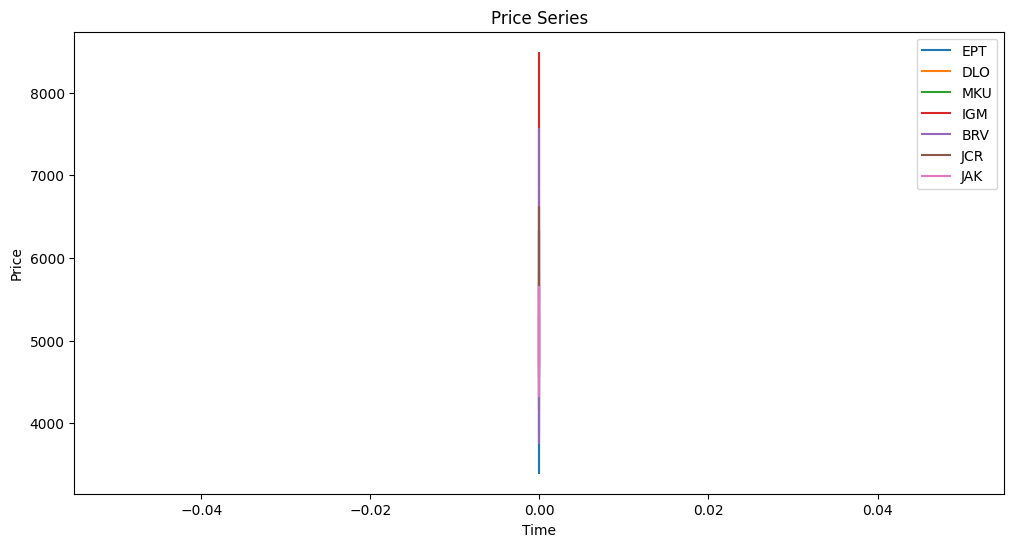

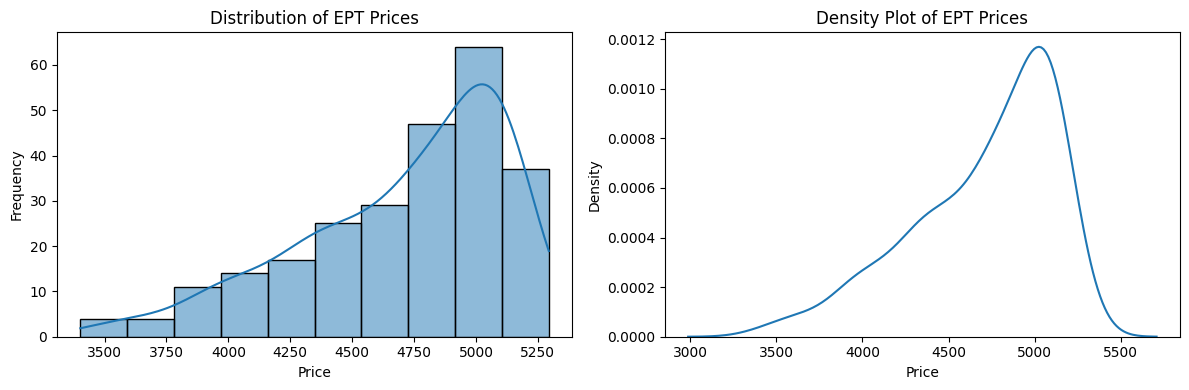

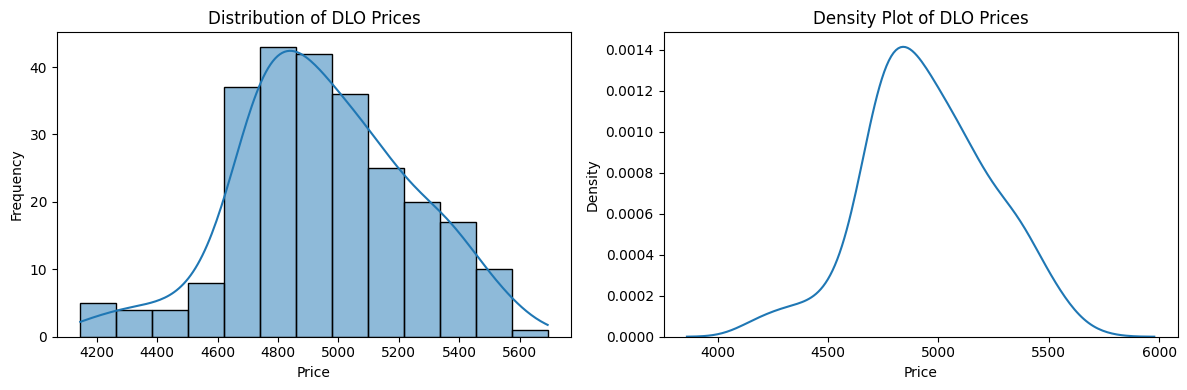

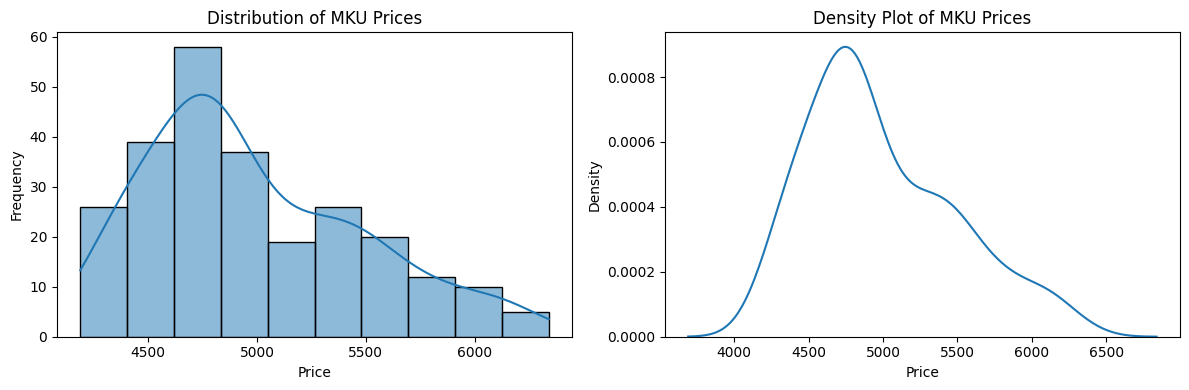

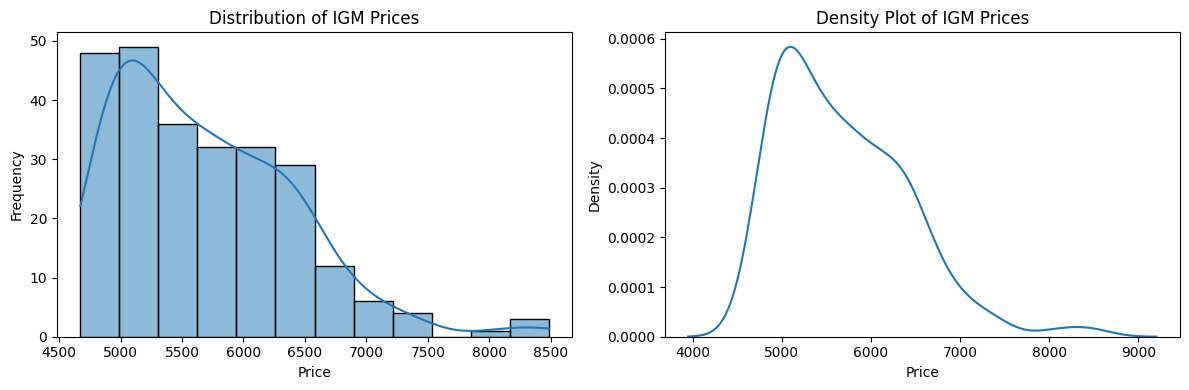

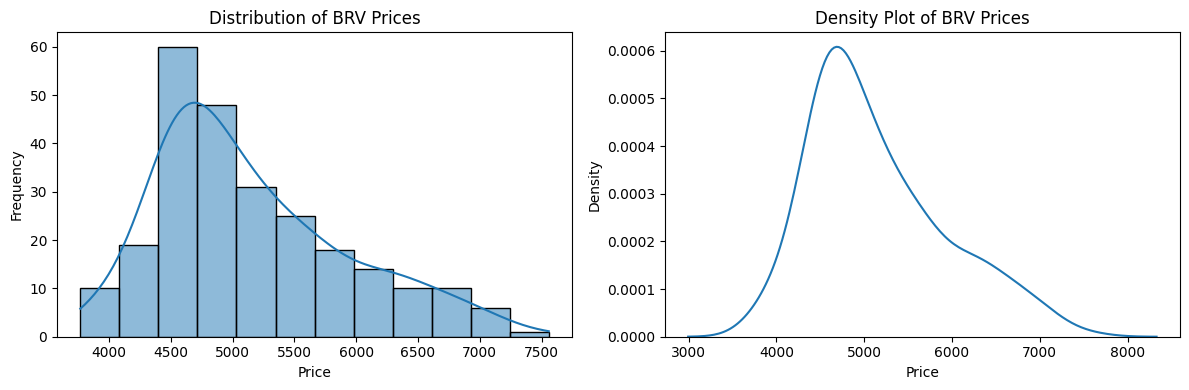

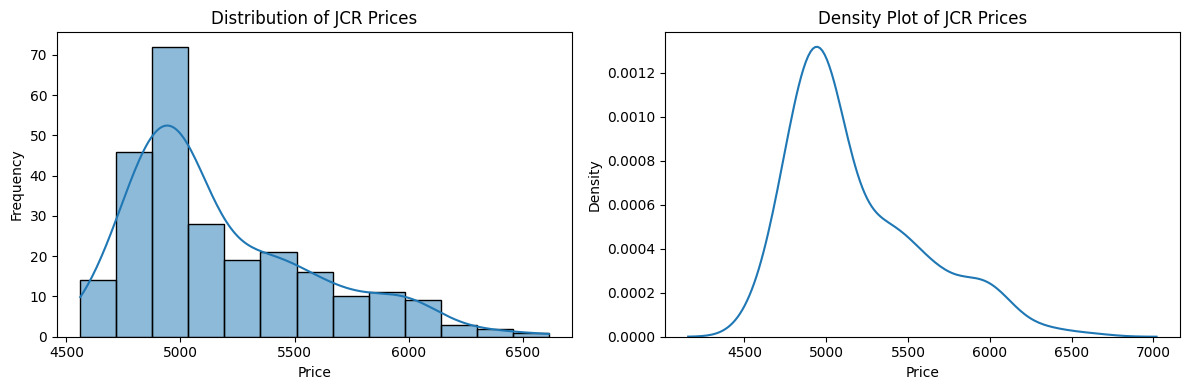

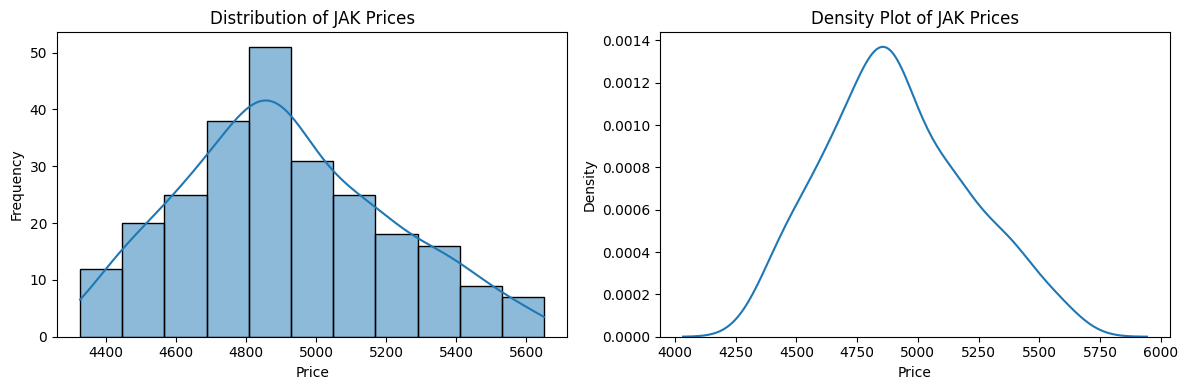

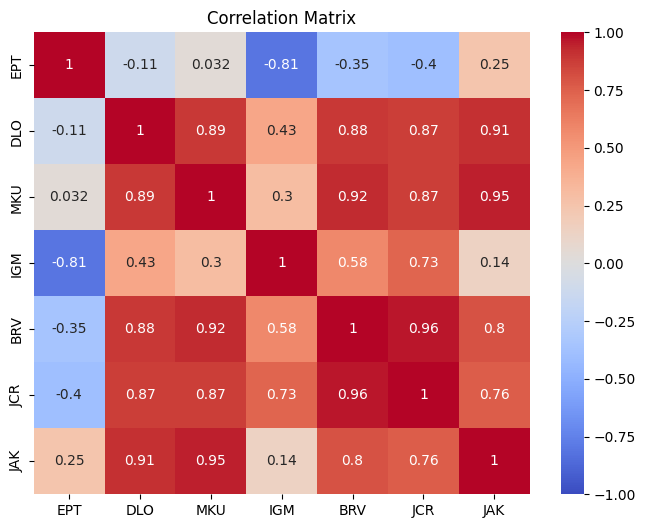

Augmented Dickey-Fuller Tests:
EPT: ADF Statistic = -7.8518935227225235, p-value = 5.572592380682554e-12
The price series of EPT is likely stationary.

DLO: ADF Statistic = -16.663245075066396, p-value = 1.5675666345258654e-29
The price series of DLO is likely stationary.

MKU: ADF Statistic = -15.772944473727154, p-value = 1.1551711911832044e-28
The price series of MKU is likely stationary.

IGM: ADF Statistic = -15.568353240953389, p-value = 2.001415107799458e-28
The price series of IGM is likely stationary.

BRV: ADF Statistic = -15.859284315213147, p-value = 9.252444370068505e-29
The price series of BRV is likely stationary.

JCR: ADF Statistic = -15.809463335277666, p-value = 1.0508980323966353e-28
The price series of JCR is likely stationary.

JAK: ADF Statistic = -16.137474652720805, p-value = 4.7143897051842774e-29
The price series of JAK is likely stationary.

Hurst Exponents:
EPT: Hurst Exponent = 0.13916067212798686
The price series of EPT exhibits mean reversion.

DLO: Hurs

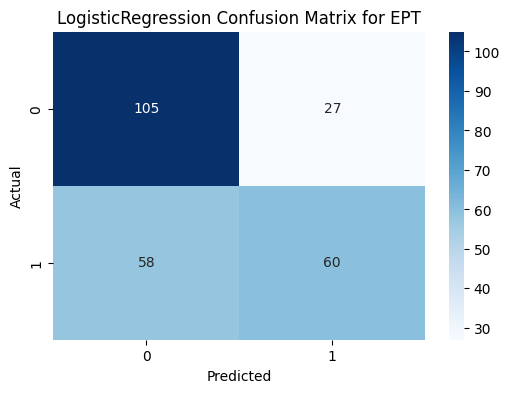


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       132
           1       0.71      0.60      0.65       118

    accuracy                           0.70       250
   macro avg       0.70      0.69      0.69       250
weighted avg       0.70      0.70      0.69       250

Accuracy: 0.696
Precision: 0.71
Recall: 0.6016949152542372
F1-score: 0.6513761467889908

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


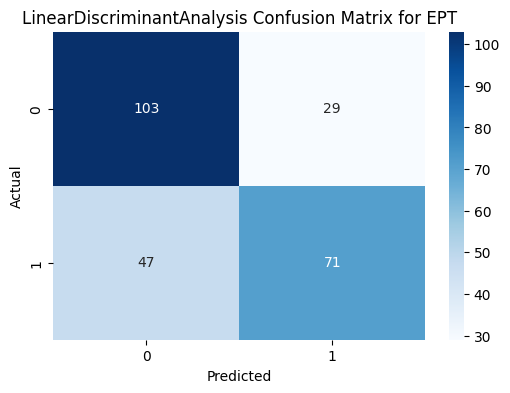


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       132
           1       0.69      0.56      0.62       118

    accuracy                           0.67       250
   macro avg       0.67      0.67      0.67       250
weighted avg       0.67      0.67      0.67       250

Accuracy: 0.672
Precision: 0.6875
Recall: 0.559322033898305
F1-score: 0.616822429906542

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


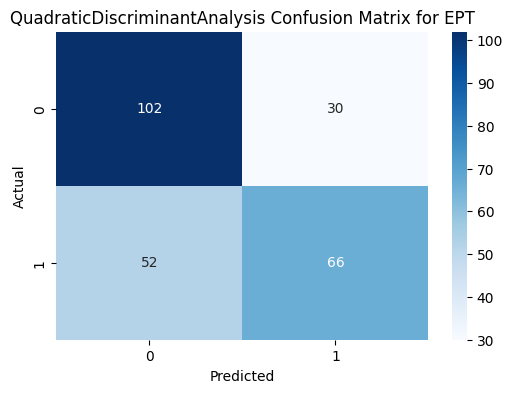


SVC Results:
              precision    recall  f1-score   support

           0       0.63      0.82      0.71       132
           1       0.69      0.46      0.55       118

    accuracy                           0.65       250
   macro avg       0.66      0.64      0.63       250
weighted avg       0.66      0.65      0.64       250

Accuracy: 0.648
Precision: 0.6923076923076923
Recall: 0.4576271186440678
F1-score: 0.5510204081632653

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


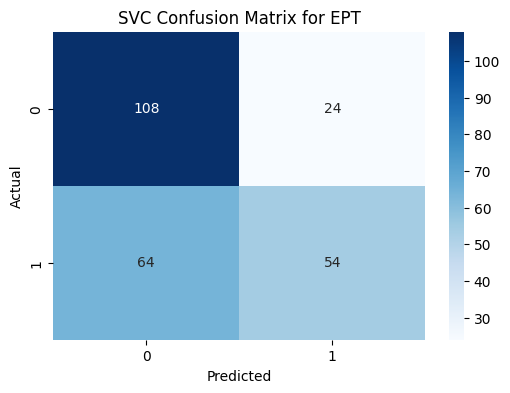


SVC Results:
              precision    recall  f1-score   support

           0       0.65      0.82      0.72       132
           1       0.71      0.51      0.59       118

    accuracy                           0.67       250
   macro avg       0.68      0.66      0.66       250
weighted avg       0.68      0.67      0.66       250

Accuracy: 0.672
Precision: 0.7142857142857143
Recall: 0.5084745762711864
F1-score: 0.594059405940594

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


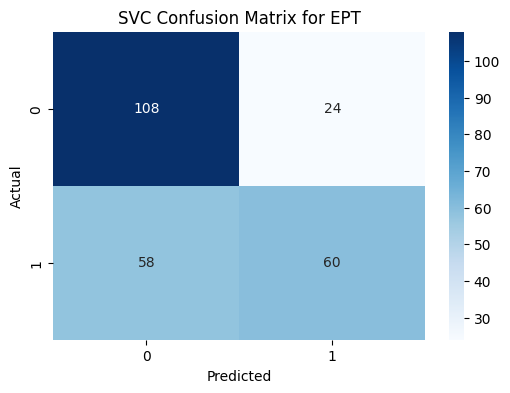


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       118

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


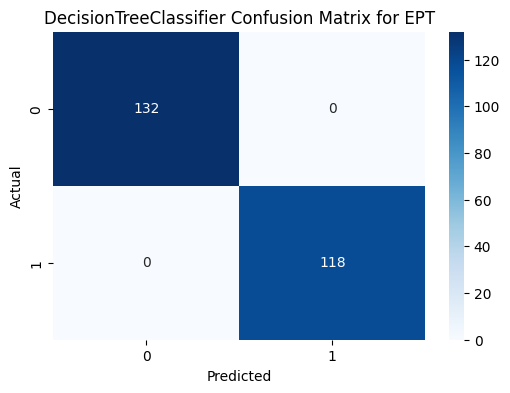


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       118

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


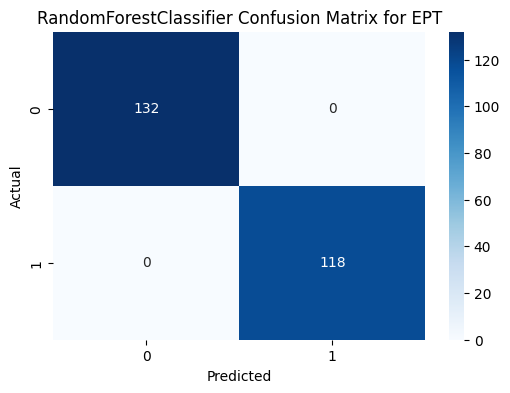


Predictive Modeling for DLO:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       129
           1       0.61      0.64      0.63       121

    accuracy                           0.63       250
   macro avg       0.63      0.63      0.63       250
weighted avg       0.63      0.63      0.63       250

Accuracy: 0.628
Precision: 0.609375
Recall: 0.6446280991735537
F1-score: 0.6265060240963856

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


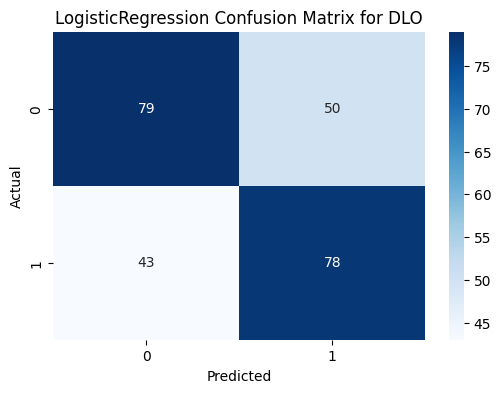


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       129
           1       0.62      0.66      0.64       121

    accuracy                           0.64       250
   macro avg       0.64      0.64      0.64       250
weighted avg       0.65      0.64      0.64       250

Accuracy: 0.644
Precision: 0.625
Recall: 0.6611570247933884
F1-score: 0.642570281124498

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


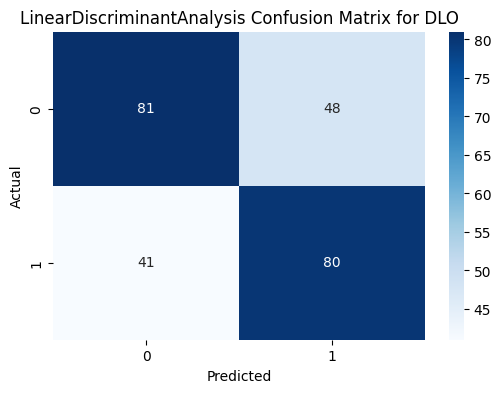


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       129
           1       0.64      0.74      0.69       121

    accuracy                           0.68       250
   macro avg       0.68      0.68      0.68       250
weighted avg       0.68      0.68      0.68       250

Accuracy: 0.676
Precision: 0.644927536231884
Recall: 0.7355371900826446
F1-score: 0.6872586872586872

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


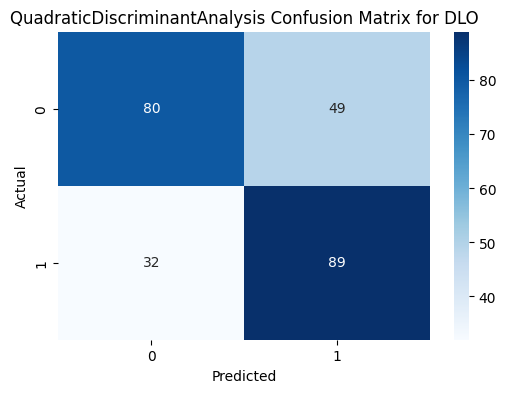


SVC Results:
              precision    recall  f1-score   support

           0       0.70      0.55      0.61       129
           1       0.61      0.74      0.67       121

    accuracy                           0.64       250
   macro avg       0.65      0.65      0.64       250
weighted avg       0.65      0.64      0.64       250

Accuracy: 0.644
Precision: 0.6081081081081081
Recall: 0.743801652892562
F1-score: 0.6691449814126395

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


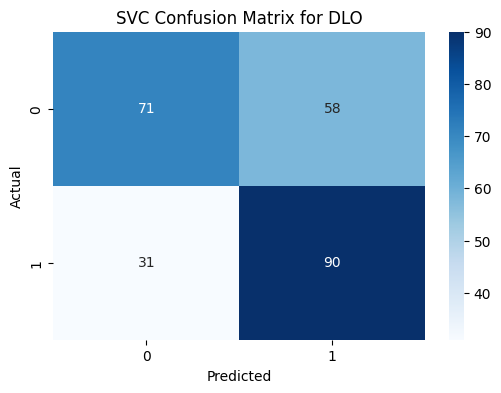


SVC Results:
              precision    recall  f1-score   support

           0       0.76      0.50      0.61       129
           1       0.61      0.83      0.71       121

    accuracy                           0.66       250
   macro avg       0.69      0.67      0.66       250
weighted avg       0.69      0.66      0.66       250

Accuracy: 0.664
Precision: 0.6121212121212121
Recall: 0.8347107438016529
F1-score: 0.7062937062937062

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


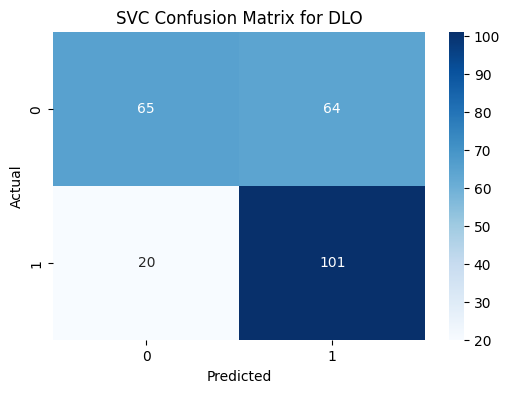


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       121

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


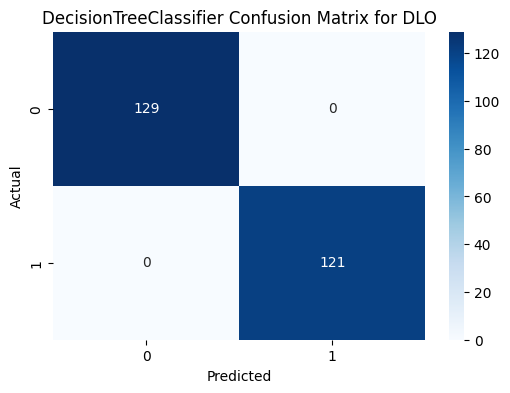


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       121

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


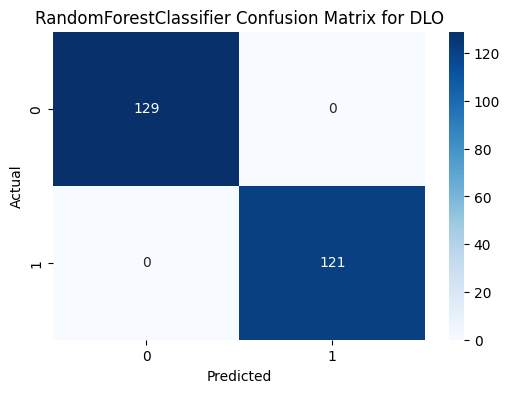


Predictive Modeling for MKU:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       117
           1       0.66      0.77      0.71       133

    accuracy                           0.67       250
   macro avg       0.67      0.66      0.66       250
weighted avg       0.67      0.67      0.66       250

Accuracy: 0.668
Precision: 0.6623376623376623
Recall: 0.7669172932330827
F1-score: 0.710801393728223

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


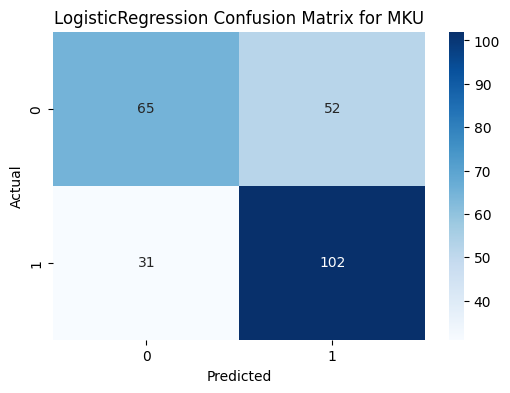


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       117
           1       0.68      0.77      0.72       133

    accuracy                           0.69       250
   macro avg       0.69      0.68      0.68       250
weighted avg       0.69      0.69      0.69       250

Accuracy: 0.688
Precision: 0.6845637583892618
Recall: 0.7669172932330827
F1-score: 0.723404255319149

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


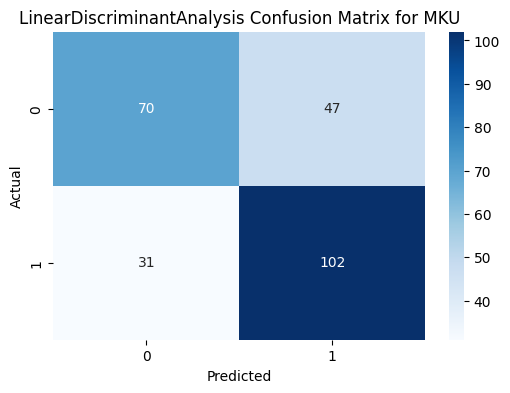


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       117
           1       0.71      0.83      0.77       133

    accuracy                           0.73       250
   macro avg       0.74      0.72      0.72       250
weighted avg       0.73      0.73      0.72       250

Accuracy: 0.728
Precision: 0.7070063694267515
Recall: 0.8345864661654135
F1-score: 0.7655172413793103

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


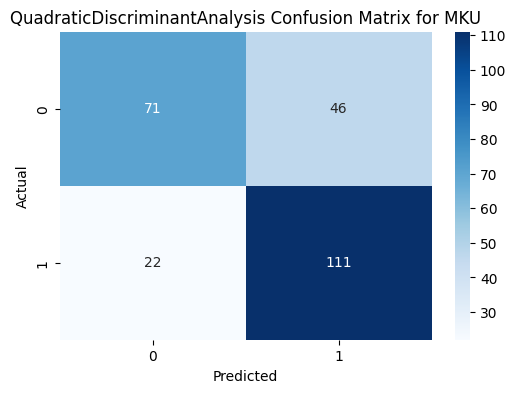


SVC Results:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       117
           1       0.65      0.85      0.74       133

    accuracy                           0.68       250
   macro avg       0.70      0.67      0.66       250
weighted avg       0.69      0.68      0.67       250

Accuracy: 0.68
Precision: 0.653179190751445
Recall: 0.849624060150376
F1-score: 0.738562091503268

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


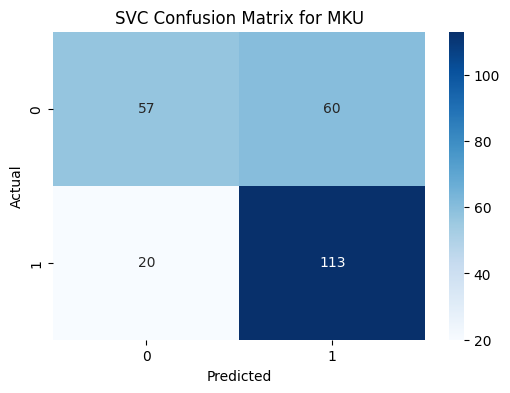


SVC Results:
              precision    recall  f1-score   support

           0       0.76      0.50      0.61       117
           1       0.66      0.86      0.75       133

    accuracy                           0.69       250
   macro avg       0.71      0.68      0.68       250
weighted avg       0.71      0.69      0.68       250

Accuracy: 0.692
Precision: 0.6627906976744186
Recall: 0.8571428571428571
F1-score: 0.7475409836065574

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


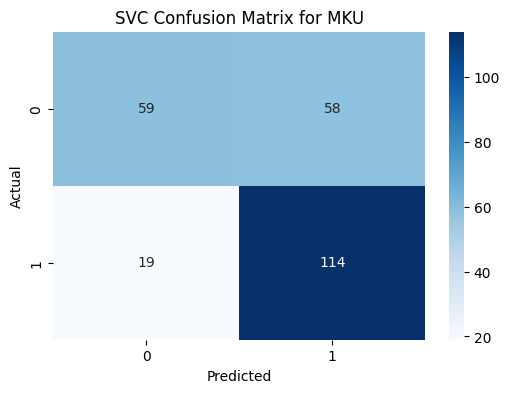


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00       133

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


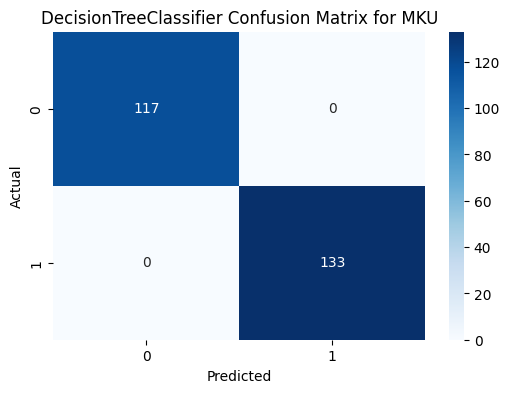


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00       133

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


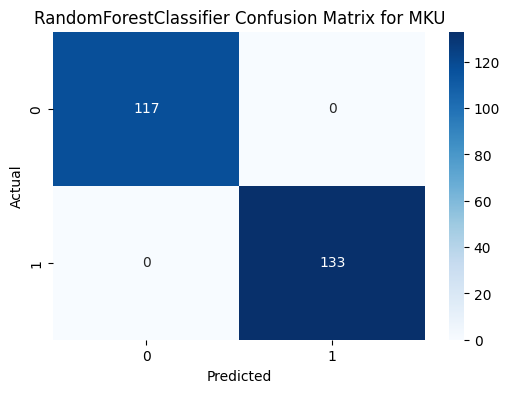


Predictive Modeling for IGM:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       124
           1       0.62      0.63      0.63       126

    accuracy                           0.62       250
   macro avg       0.62      0.62      0.62       250
weighted avg       0.62      0.62      0.62       250

Accuracy: 0.62
Precision: 0.6201550387596899
Recall: 0.6349206349206349
F1-score: 0.6274509803921569

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


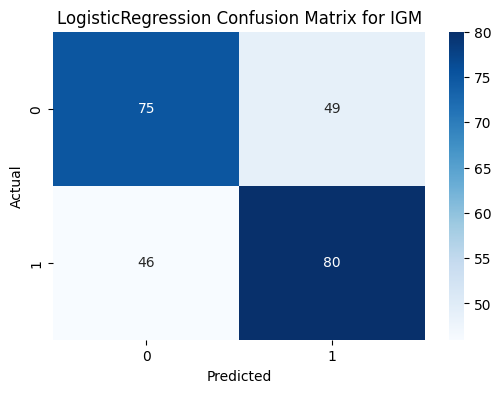


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       124
           1       0.69      0.72      0.71       126

    accuracy                           0.70       250
   macro avg       0.70      0.70      0.70       250
weighted avg       0.70      0.70      0.70       250

Accuracy: 0.696
Precision: 0.6893939393939394
Recall: 0.7222222222222222
F1-score: 0.7054263565891473

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


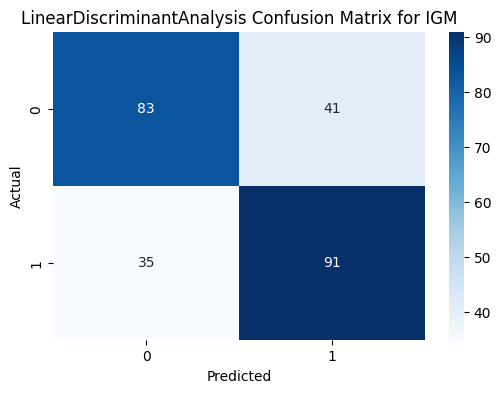


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       124
           1       0.65      0.76      0.70       126

    accuracy                           0.68       250
   macro avg       0.68      0.68      0.67       250
weighted avg       0.68      0.68      0.67       250

Accuracy: 0.676
Precision: 0.6530612244897959
Recall: 0.7619047619047619
F1-score: 0.7032967032967034

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


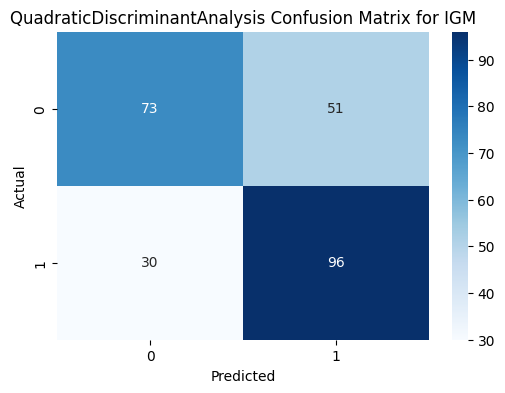


SVC Results:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       124
           1       0.65      0.68      0.67       126

    accuracy                           0.66       250
   macro avg       0.66      0.66      0.66       250
weighted avg       0.66      0.66      0.66       250

Accuracy: 0.656
Precision: 0.6515151515151515
Recall: 0.6825396825396826
F1-score: 0.6666666666666666

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


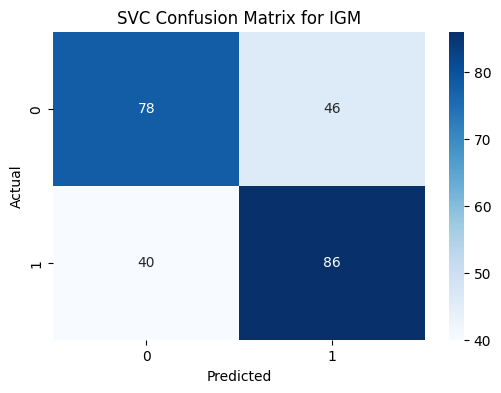


SVC Results:
              precision    recall  f1-score   support

           0       0.75      0.58      0.65       124
           1       0.66      0.81      0.73       126

    accuracy                           0.70       250
   macro avg       0.71      0.70      0.69       250
weighted avg       0.71      0.70      0.69       250

Accuracy: 0.696
Precision: 0.6623376623376623
Recall: 0.8095238095238095
F1-score: 0.7285714285714285

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


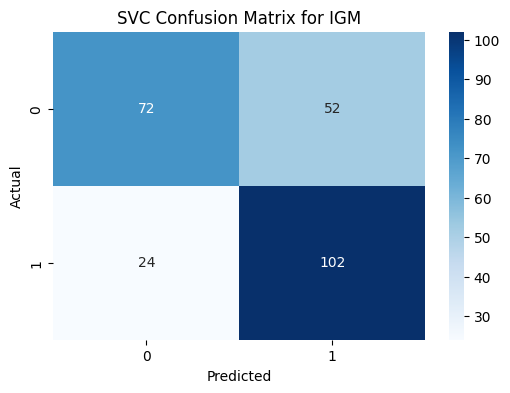


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       126

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


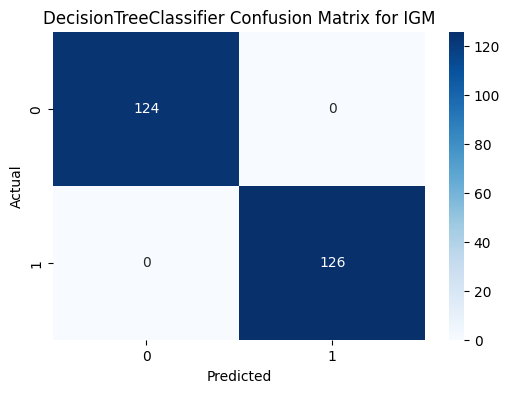


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       126

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


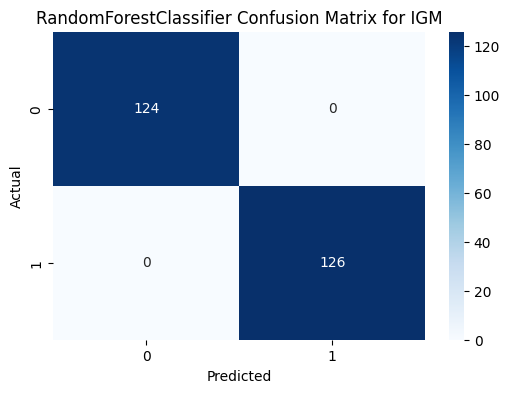


Predictive Modeling for BRV:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       129
           1       0.61      0.63      0.62       121

    accuracy                           0.62       250
   macro avg       0.62      0.62      0.62       250
weighted avg       0.62      0.62      0.62       250

Accuracy: 0.624
Precision: 0.608
Recall: 0.628099173553719
F1-score: 0.6178861788617886

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


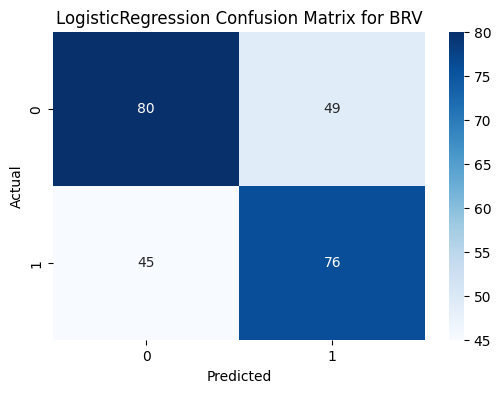


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66       129
           1       0.64      0.72      0.68       121

    accuracy                           0.67       250
   macro avg       0.67      0.67      0.67       250
weighted avg       0.68      0.67      0.67       250

Accuracy: 0.672
Precision: 0.6444444444444445
Recall: 0.71900826446281
F1-score: 0.6796875

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


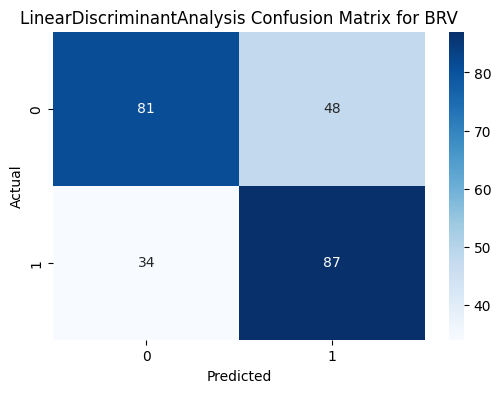


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.74      0.67      0.71       129
           1       0.68      0.75      0.72       121

    accuracy                           0.71       250
   macro avg       0.71      0.71      0.71       250
weighted avg       0.71      0.71      0.71       250

Accuracy: 0.712
Precision: 0.6842105263157895
Recall: 0.7520661157024794
F1-score: 0.7165354330708661

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


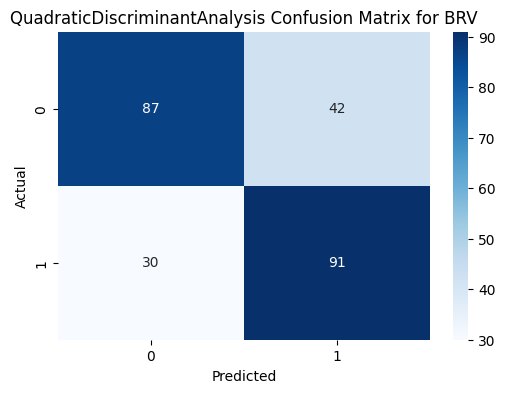


SVC Results:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       129
           1       0.63      0.72      0.67       121

    accuracy                           0.66       250
   macro avg       0.66      0.66      0.66       250
weighted avg       0.66      0.66      0.66       250

Accuracy: 0.66
Precision: 0.6304347826086957
Recall: 0.71900826446281
F1-score: 0.6718146718146718

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


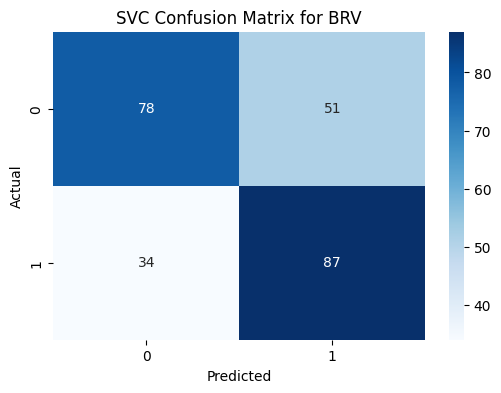


SVC Results:
              precision    recall  f1-score   support

           0       0.80      0.54      0.65       129
           1       0.64      0.86      0.73       121

    accuracy                           0.70       250
   macro avg       0.72      0.70      0.69       250
weighted avg       0.72      0.70      0.69       250

Accuracy: 0.696
Precision: 0.6380368098159509
Recall: 0.859504132231405
F1-score: 0.7323943661971831

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


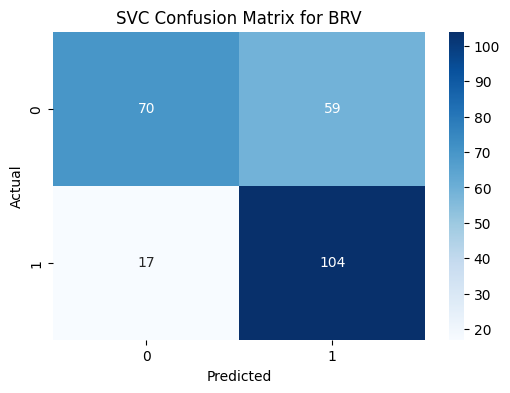


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       121

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


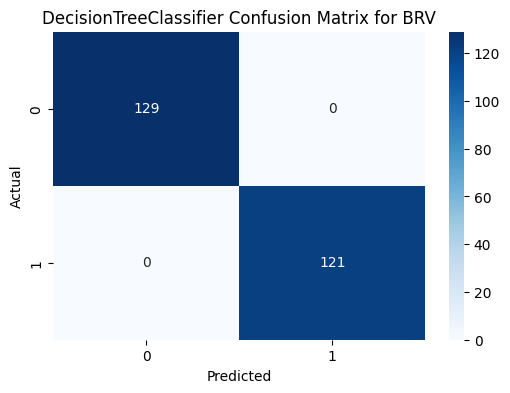


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       121

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


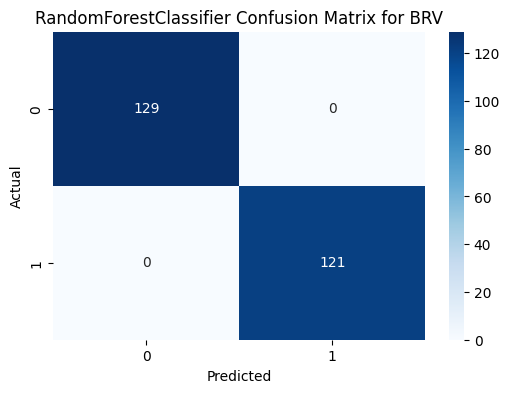


Predictive Modeling for JCR:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       132
           1       0.63      0.63      0.63       118

    accuracy                           0.65       250
   macro avg       0.65      0.65      0.65       250
weighted avg       0.65      0.65      0.65       250

Accuracy: 0.648
Precision: 0.6271186440677966
Recall: 0.6271186440677966
F1-score: 0.6271186440677966

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


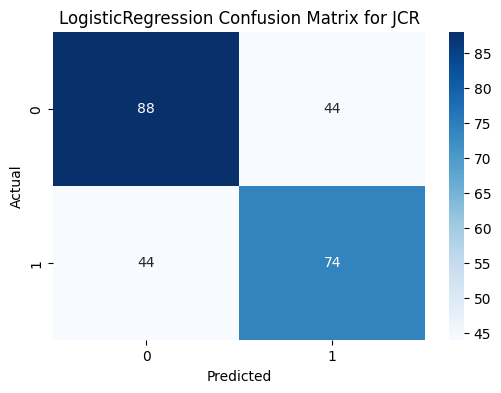


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       132
           1       0.66      0.68      0.67       118

    accuracy                           0.68       250
   macro avg       0.68      0.68      0.68       250
weighted avg       0.68      0.68      0.68       250

Accuracy: 0.68
Precision: 0.6557377049180327
Recall: 0.6779661016949152
F1-score: 0.6666666666666666

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


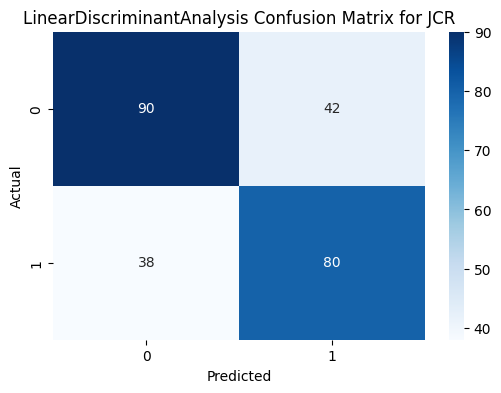


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       132
           1       0.65      0.73      0.69       118

    accuracy                           0.68       250
   macro avg       0.69      0.69      0.68       250
weighted avg       0.69      0.68      0.68       250

Accuracy: 0.684
Precision: 0.6466165413533834
Recall: 0.7288135593220338
F1-score: 0.6852589641434262

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


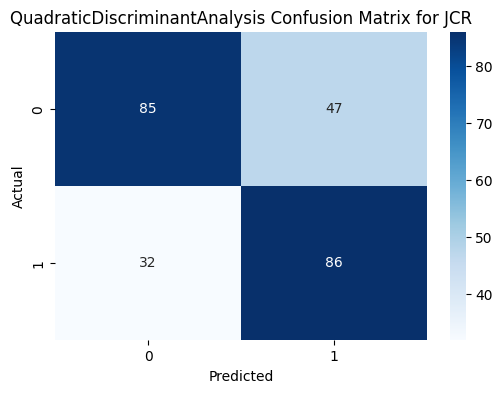


SVC Results:
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       132
           1       0.62      0.69      0.66       118

    accuracy                           0.66       250
   macro avg       0.66      0.66      0.66       250
weighted avg       0.66      0.66      0.66       250

Accuracy: 0.656
Precision: 0.6212121212121212
Recall: 0.6949152542372882
F1-score: 0.656

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


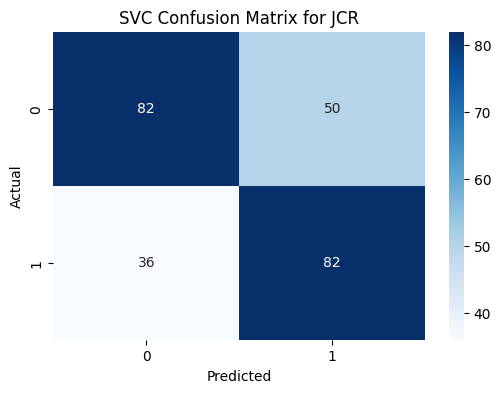


SVC Results:
              precision    recall  f1-score   support

           0       0.77      0.62      0.69       132
           1       0.65      0.80      0.72       118

    accuracy                           0.70       250
   macro avg       0.71      0.71      0.70       250
weighted avg       0.72      0.70      0.70       250

Accuracy: 0.704
Precision: 0.6527777777777778
Recall: 0.7966101694915254
F1-score: 0.7175572519083969

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


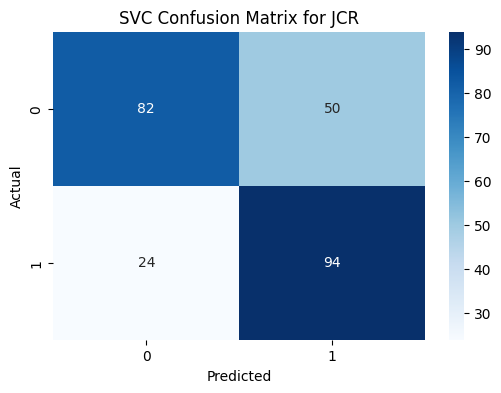


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       118

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


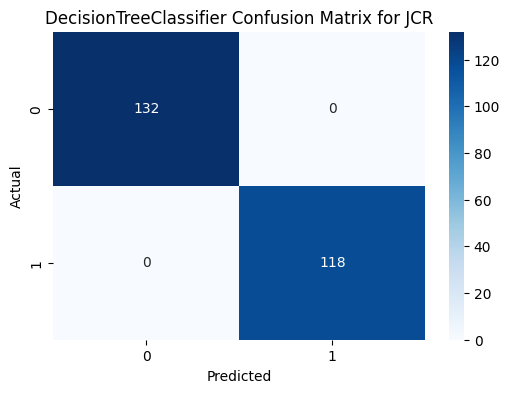


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       118

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


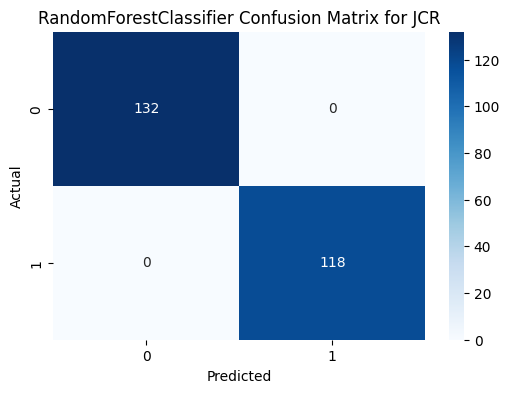


Predictive Modeling for JAK:

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       122
           1       0.70      0.75      0.72       128

    accuracy                           0.71       250
   macro avg       0.71      0.71      0.71       250
weighted avg       0.71      0.71      0.71       250

Accuracy: 0.708
Precision: 0.7007299270072993
Recall: 0.75
F1-score: 0.7245283018867924

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


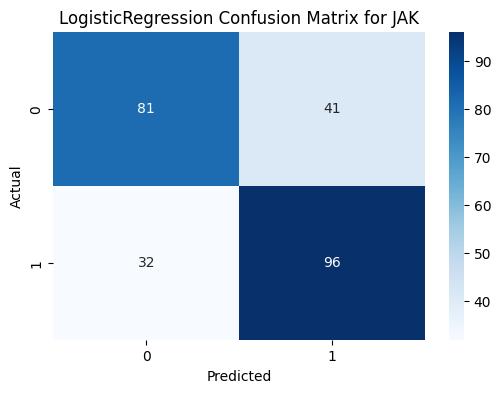


LinearDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       122
           1       0.72      0.72      0.72       128

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.72       250
weighted avg       0.72      0.72      0.72       250

Accuracy: 0.716
Precision: 0.7244094488188977
Recall: 0.71875
F1-score: 0.7215686274509804

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


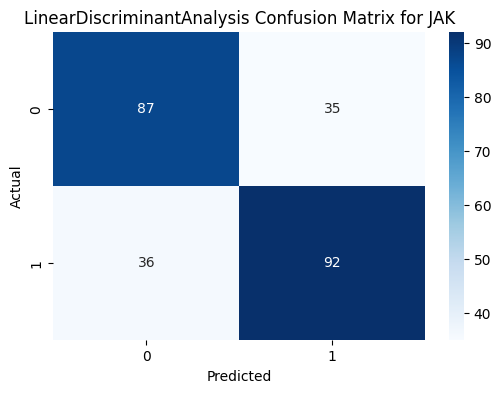


QuadraticDiscriminantAnalysis Results:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       122
           1       0.72      0.75      0.74       128

    accuracy                           0.72       250
   macro avg       0.72      0.72      0.72       250
weighted avg       0.72      0.72      0.72       250

Accuracy: 0.724
Precision: 0.7218045112781954
Recall: 0.75
F1-score: 0.735632183908046

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


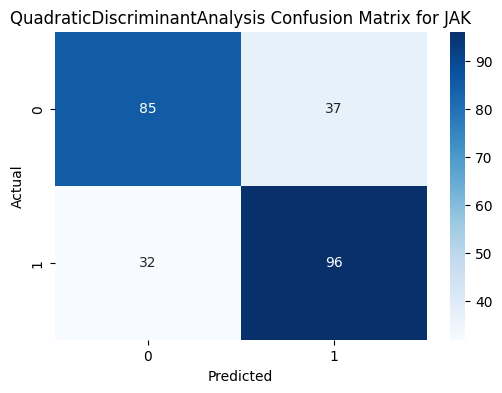


SVC Results:
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       122
           1       0.69      0.77      0.73       128

    accuracy                           0.70       250
   macro avg       0.71      0.70      0.70       250
weighted avg       0.71      0.70      0.70       250

Accuracy: 0.704
Precision: 0.6875
Recall: 0.7734375
F1-score: 0.7279411764705882

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


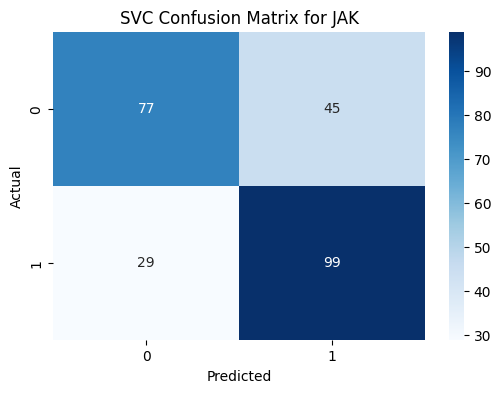


SVC Results:
              precision    recall  f1-score   support

           0       0.78      0.60      0.68       122
           1       0.69      0.84      0.75       128

    accuracy                           0.72       250
   macro avg       0.73      0.72      0.71       250
weighted avg       0.73      0.72      0.72       250

Accuracy: 0.72
Precision: 0.6858974358974359
Recall: 0.8359375
F1-score: 0.7535211267605634

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


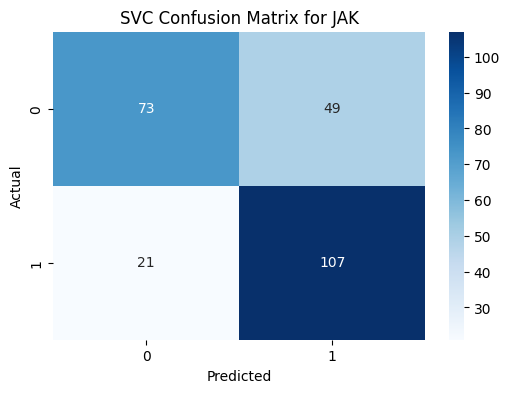


DecisionTreeClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       128

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


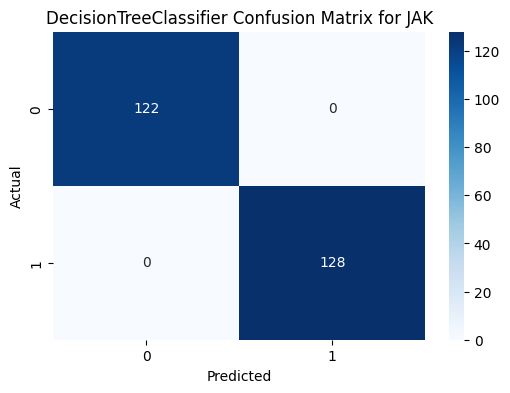


RandomForestClassifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       128

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Analysis:
- Accuracy measures the overall correctness of predictions.
- Precision indicates the proportion of true positive predictions among the positive predictions.
- Recall measures the proportion of actual positive instances that were correctly predicted.
- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.


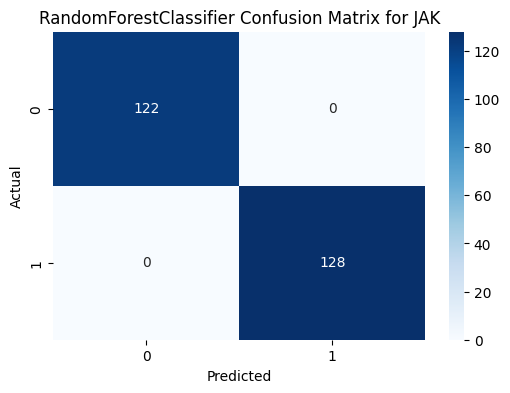

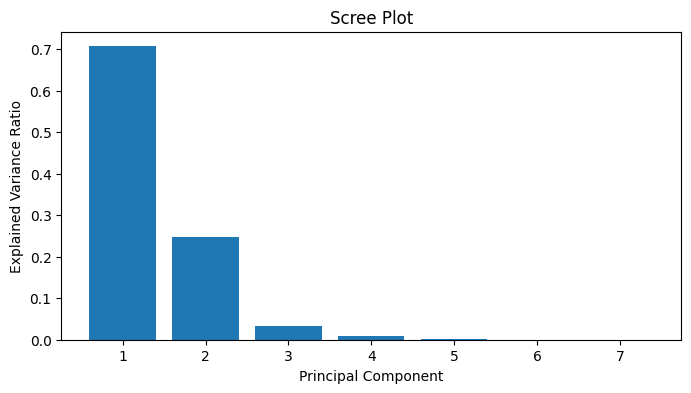

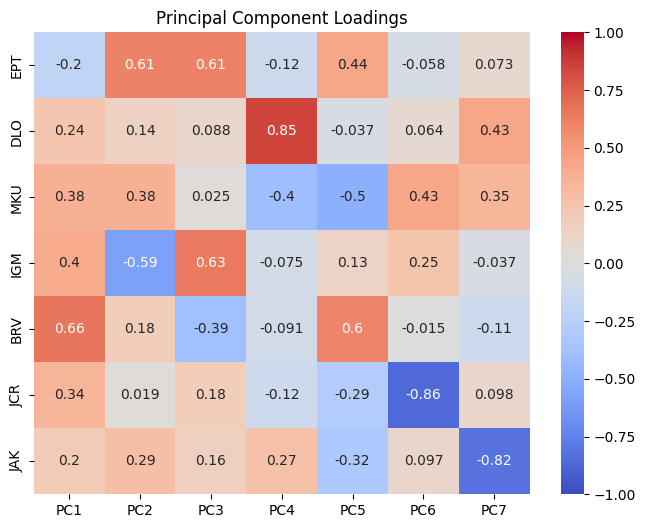

In [8]:
analysis = TradingAnalysis('Case1_Historical_Amended.csv')
analysis.plot_price_series()
analysis.plot_distributions()
analysis.plot_correlation_matrix()
analysis.augmented_dickey_fuller_test()
analysis.hurst_exponent()
analysis.cointegration_test()
analysis.granger_causality_test()
analysis.predictive_modeling()
analysis.principal_component_analysis()
